In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def preprocess(image_input):
    """Handle both file paths and image arrays"""
    if isinstance(image_input, str):  # File path
        image = cv2.imread(image_input)
    else:  # Already loaded image array
        image = image_input.copy()
    
    if image is None:
        raise ValueError("Could not read image")
    
    # Common processing for both cases
    image = cv2.resize(image, (256, 256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image.astype(np.float32) / 255.0

In [17]:
def trimmed_median_filter(image, window_size=3, d=2):
    # Convert float [0,1] to uint8 [0-255]
    image_uint8 = (image * 255).astype(np.uint8)
    # Apply padding and median filtering
    padded = cv2.copyMakeBorder(image_uint8, d, d, d, d, cv2.BORDER_REFLECT)
    filtered = cv2.medianBlur(padded, window_size)
    # Remove padding and convert back to float [0,1]
    return filtered[d:-d, d:-d].astype(np.float32) / 255.0

In [18]:
# Colore corection using gray world algorithm
def gray_world_balance(image):
    avg = np.mean(image, axis=(0, 1))
    gray = np.mean(avg)
    scale = gray / (avg + 1e-6)
    
    # Boost saturation in HSV space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * 1.3, 0, 1)  # 30% saturation boost
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return np.clip(image * scale, 0, 1)

In [19]:
# Contrast Enhancement using CLAHE
def apply_clahe(image):
    lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16, 16))  # Increased
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB) / 255.0

In [20]:
# Haze Removal using Laplacian Decomposition
def laplacian_haze_removal(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Multi-scale Laplacian
    laplacian1 = cv2.Laplacian(gray, cv2.CV_64F, ksize=3)
    laplacian2 = cv2.Laplacian(gray, cv2.CV_64F, ksize=5)
    combined = 0.6 * laplacian1 + 0.4 * laplacian2  # Weighted combination
    
    combined = cv2.normalize(combined, None, 0, 0.4, cv2.NORM_MINMAX)  # Reduced strength
    enhanced = image - combined[..., np.newaxis]
    return np.clip(enhanced, 0, 1)

In [27]:
def full_pipeline(input_path):
    """Complete processing pipeline with error handling"""
    try:
        # Preprocess (handles both paths and arrays)
        image = preprocess(input_path)
        
        # Pipeline steps
        denoised = trimmed_median_filter(image)
        color_balanced = gray_world_balance(denoised)
        clahe_enhanced = apply_clahe(color_balanced)
        final = laplacian_haze_removal(clahe_enhanced)
        
        return {'final': final}
    
    except Exception as e:
        print(f"Pipeline failed: {str(e)}")
        return None

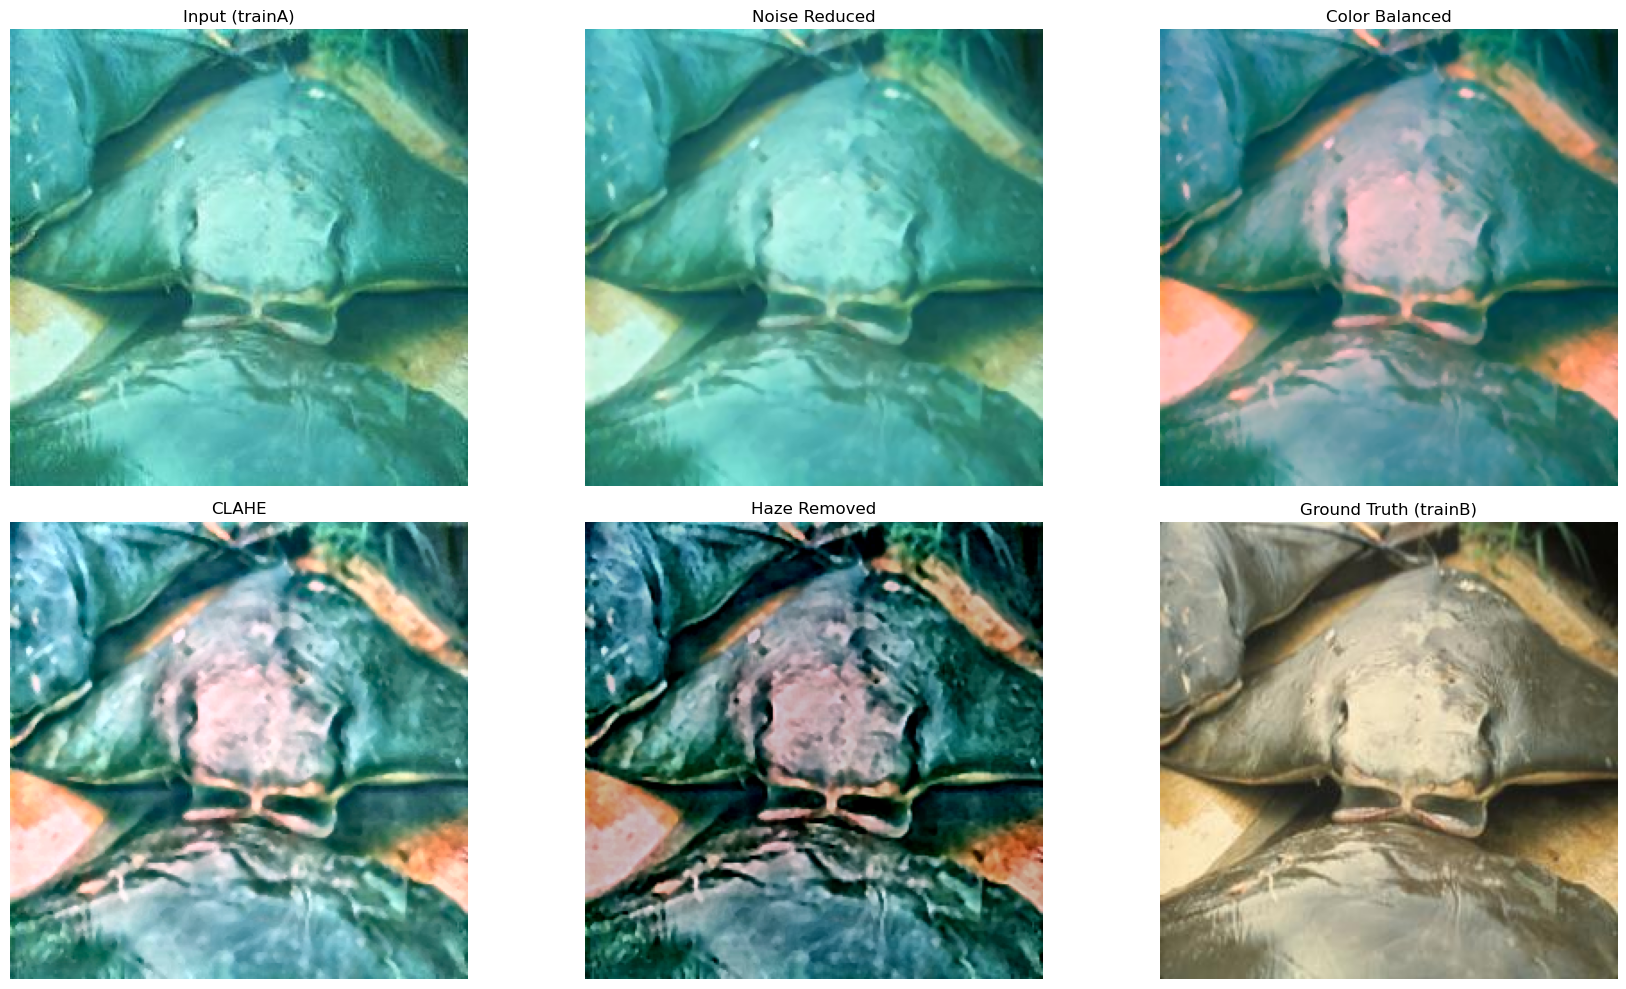

In [ ]:
# Get input from trainA and ground truth from trainB
input_path = "dataset/trainA/n01496331_49.jpg"
gt_path = "dataset/trainB/n01496331_49.jpg"  # Same filename in trainB

# Process trainA image through pipeline
input_image = preprocess(input_path)
filtered = trimmed_median_filter(input_image)
color_balanced = gray_world_balance(filtered)
contrast_enhanced = apply_clahe(color_balanced)
final_image = laplacian_haze_removal(contrast_enhanced)

# Get ground truth for comparison
gt_image = preprocess(gt_path)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
titles = ["Input (trainA)", "Noise Reduced", "Color Balanced", 
          "CLAHE", "Haze Removed", "Ground Truth (trainB)"]

for ax, img, title in zip(axes.flat, 
                         [input_image, filtered, color_balanced, 
                          contrast_enhanced, final_image, gt_image],
                         titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    
plt.tight_layout()
plt.show()